In [1]:
import os
# Отключает все логи TensorFlow (0 - все, 1 - предупреждения, 2 - ошибки, 3 - критичные ошибки)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from neptune_tensorflow_keras import NeptuneCallback  
from sklearn.model_selection import cross_val_score
from sklearn import datasets
import pandas as pd
import numpy as np
from typing import List, Union
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import neptune
import optuna
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
import itertools
from sklearn.preprocessing import LabelEncoder
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray import train
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from dotenv import load_dotenv
import matplotlib.pyplot as plt

In [3]:
paris = pd.read_csv('content/ParisHousing.csv')

In [4]:
paris

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1726,89,0,1,5,73133,7,6,2009,0,1,9311,1698,218,0,4,176425.9
9996,44403,29,1,1,12,34606,9,4,1990,0,1,9061,1742,230,0,0,4448474.0
9997,83841,3,0,0,69,80933,10,10,2005,1,1,8304,7730,345,1,9,8390030.5
9998,59036,70,0,0,96,55856,1,3,2010,0,1,2590,6174,339,1,4,5905107.0


In [5]:
paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [6]:
X = paris.drop(columns=['price'])  
y = paris['price'] 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                  random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
load_dotenv()

True

In [20]:
run = neptune.init_run(
        project=os.getenv("NEPTUNE_PROJECT"), 
        api_token=os.getenv("NEPTUNE_API_TOKEN"),
        capture_stdout=True,
        capture_stderr=True,
        capture_traceback=True,
        capture_hardware_metrics=True
    ) 

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/saatarko/financescoring/e/FIN-15


In [11]:
os.makedirs("content/board", exist_ok=True)

In [12]:
def objective(trial):
    # Оптимизируемые гиперпараметры
    lr = trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    num_layers = trial.suggest_int('num_layers', 2, 5)
    layers = trial.suggest_categorical('layers', [35, 50, 75, 100, 250, 350, 500])
    dropout = trial.suggest_float('dropout', 0.1, 0.3, step=0.1)
    activation = trial.suggest_categorical('activation', ["relu", "leaky_relu"])
    optimizer_name = trial.suggest_categorical('optimizer', ["Adam", "SGD", "RMSprop"])

    optimizer = {
        "Adam": tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0),
        "SGD": tf.keras.optimizers.SGD(learning_rate=lr, clipnorm=1.0),
        "RMSprop": tf.keras.optimizers.RMSprop(learning_rate=lr, clipnorm=1.0),
    }[optimizer_name]

    # Создаём модель
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1],)))

    for _ in range(num_layers):
        model.add(tf.keras.layers.Dense(layers, activation=activation if activation != "leaky_relu" else None))
        if activation == "leaky_relu":
            model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(1, activation=None))  
    
    model.compile(
        loss="mse",
        optimizer=optimizer,
        metrics=['mae'] 
    )

    # Логируем гиперпараметры 
    run[f'trials/{trial.number}/parameters'] = {
        'learning_rate': lr,
        'batch_size': batch_size,
        'num_layers': num_layers,
        'layers': layers,
        'dropout': dropout,
        'activation': activation,
        'optimizer': optimizer_name
    }

    neptune_cbk = NeptuneCallback(run=run, base_namespace=f"trials/{trial.number}/metrics")
    tensorboard = TensorBoard(log_dir=f"content/board/trial_{trial.number}", histogram_freq=1)  # Разные логи для trials

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        neptune_cbk,
        tensorboard
    ]

    history = model.fit(
        X_train,
        y_train,
        epochs=500,  # Max ограничение
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=0
    )

    # Оцениваем модель
    loss, mae = model.evaluate(X_test, y_test, verbose=0)

    # Логируем метрики в Neptune
    for epoch in range(len(history.history['loss'])):
        run[f"trials/{trial.number}/metrics/train_loss"].log(history.history['loss'][epoch], step=epoch)
        run[f"trials/{trial.number}/metrics/val_loss"].log(history.history['val_loss'][epoch], step=epoch)
        run[f"trials/{trial.number}/metrics/train_mae"].log(history.history['mae'][epoch], step=epoch)
        run[f"trials/{trial.number}/metrics/val_mae"].log(history.history['val_mae'][epoch], step=epoch)

    # Финальные метрики
    run[f"trials/{trial.number}/final/loss"] = loss
    run[f"trials/{trial.number}/final/mae"] = mae  

    return mae


In [21]:
# Оптимизация с Optuna
study = optuna.create_study(direction="minimize", study_name="Neptune_Optimization")

study.optimize(objective, n_trials=20)

# Логируем лучшие параметры
best_params = study.best_params
best_mae = study.best_value

run.stop()

print(f"Best parameters: {best_params}")
print(f"Best mae: {best_mae}")

[I 2025-03-24 21:37:53,796] A new study created in memory with name: Neptune_Optimization


[I 2025-03-24 21:38:19,631] Trial 0 finished with value: 2809771.0 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 5, 'layers': 350, 'dropout': 0.3, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 0 with value: 2809771.0.


[I 2025-03-24 21:38:28,329] Trial 1 finished with value: 630936.6875 and parameters: {'learning_rate': 0.1, 'batch_size': 32, 'num_layers': 5, 'layers': 35, 'dropout': 0.2, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 1 with value: 630936.6875.


[I 2025-03-24 21:38:46,565] Trial 2 finished with value: 749107459129344.0 and parameters: {'learning_rate': 0.1, 'batch_size': 128, 'num_layers': 5, 'layers': 500, 'dropout': 0.2, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 1 with value: 630936.6875.


[I 2025-03-24 21:39:08,164] Trial 3 finished with value: 29917.46484375 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 5, 'layers': 350, 'dropout': 0.2, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 3 with value: 29917.46484375.


[I 2025-03-24 21:39:15,234] Trial 4 finished with value: 86938.6171875 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'num_layers': 5, 'layers': 35, 'dropout': 0.1, 'activation': 'leaky_relu', 'optimizer': 'SGD'}. Best is trial 3 with value: 29917.46484375.


[I 2025-03-24 21:39:25,192] Trial 5 finished with value: 1114127.375 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'num_layers': 5, 'layers': 75, 'dropout': 0.1, 'activation': 'relu', 'optimizer': 'RMSprop'}. Best is trial 3 with value: 29917.46484375.


[I 2025-03-24 21:39:57,192] Trial 6 finished with value: 8909.40625 and parameters: {'learning_rate': 0.1, 'batch_size': 64, 'num_layers': 3, 'layers': 350, 'dropout': 0.3, 'activation': 'relu', 'optimizer': 'SGD'}. Best is trial 6 with value: 8909.40625.


[I 2025-03-24 21:40:32,381] Trial 7 finished with value: 8929.3916015625 and parameters: {'learning_rate': 0.01, 'batch_size': 128, 'num_layers': 3, 'layers': 500, 'dropout': 0.1, 'activation': 'leaky_relu', 'optimizer': 'SGD'}. Best is trial 6 with value: 8909.40625.


[I 2025-03-24 21:41:00,811] Trial 8 finished with value: 5530.75390625 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 2, 'layers': 500, 'dropout': 0.2, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:41:27,975] Trial 9 finished with value: 45178.6015625 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'num_layers': 5, 'layers': 250, 'dropout': 0.3, 'activation': 'leaky_relu', 'optimizer': 'SGD'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:41:40,469] Trial 10 finished with value: 7879.46923828125 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 2, 'layers': 100, 'dropout': 0.2, 'activation': 'leaky_relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:41:48,161] Trial 11 finished with value: 11626.232421875 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 2, 'layers': 100, 'dropout': 0.2, 'activation': 'leaky_relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:41:57,093] Trial 12 finished with value: 39696.69140625 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 2, 'layers': 50, 'dropout': 0.2, 'activation': 'leaky_relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:42:05,178] Trial 13 finished with value: 10031.5654296875 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 2, 'layers': 100, 'dropout': 0.2, 'activation': 'leaky_relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:42:15,238] Trial 14 finished with value: 12745.6396484375 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 3, 'layers': 100, 'dropout': 0.1, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:42:50,552] Trial 15 finished with value: 15731.091796875 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 4, 'layers': 500, 'dropout': 0.3, 'activation': 'leaky_relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:42:59,604] Trial 16 finished with value: 20786.01171875 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'layers': 250, 'dropout': 0.2, 'activation': 'leaky_relu', 'optimizer': 'RMSprop'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:43:06,007] Trial 17 finished with value: 59393.10546875 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 4, 'layers': 50, 'dropout': 0.1, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:43:12,806] Trial 18 finished with value: 40056.69140625 and parameters: {'learning_rate': 0.001, 'batch_size': 128, 'num_layers': 3, 'layers': 75, 'dropout': 0.3, 'activation': 'relu', 'optimizer': 'Adam'}. Best is trial 8 with value: 5530.75390625.


[I 2025-03-24 21:43:47,330] Trial 19 finished with value: 4771.98681640625 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'layers': 500, 'dropout': 0.2, 'activation': 'leaky_relu', 'optimizer': 'RMSprop'}. Best is trial 19 with value: 4771.98681640625.


[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 208 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 208 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/saatarko/financescoring/e/FIN-15/metadata
Best parameters: {'learning_rate': 0.001, 'batch_size': 64, 'num_layers': 2, 'layers': 500, 'dropout': 0.2, 'activation': 'leaky_relu', 'optimizer': 'RMSprop'}
Best mae: 4771.98681640625


In [22]:
# Получим данные из Optuna
best_params = study.best_params
best_lr = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_dropout = best_params['dropout']
best_activation = best_params['activation']
best_optimizer = best_params['optimizer']

In [23]:
print(f"best_lr {best_lr}")
print(f"best_batch_size {best_batch_size}") 
print(f"best_dropout {best_dropout}") 
print(f"best_activation {best_activation}") 
print(f"best_optimizer {best_optimizer}") 

best_lr 0.001
best_batch_size 64
best_dropout 0.2
best_activation leaky_relu
best_optimizer RMSprop


In [26]:
# Создаём модель

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Входной слой
    keras.layers.Dense(64),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.Dropout(best_dropout),
    keras.layers.Dense(32),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.Dense(1)  # Выходной слой
])

callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ]

# Компиляция модели
model.compile(optimizer=tf.keras.optimizers.RMSprop(best_lr), 
              loss=tf.keras.losses.Huber(delta=1.0), 
              metrics=['mae'])

# История обучения хранится в объекте history
history = model.fit(X_train_scaled, y_train, epochs=600, batch_size=best_batch_size, 
                    validation_data=(X_test_scaled, y_test), verbose=1, callbacks=callbacks)


Epoch 1/600


/home/saatarko/.conda/envs/HomeworkDS/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4934657.5000 - mae: 4934658.5000 - val_loss: 5110843.5000 - val_mae: 5110843.5000 - learning_rate: 0.0010
Epoch 2/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4991121.0000 - mae: 4991122.0000 - val_loss: 5110770.0000 - val_mae: 5110770.0000 - learning_rate: 0.0010
Epoch 3/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4950919.0000 - mae: 4950919.5000 - val_loss: 5110626.0000 - val_mae: 5110626.5000 - learning_rate: 0.0010
Epoch 4/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4942313.5000 - mae: 4942314.0000 - val_loss: 5110390.5000 - val_mae: 5110391.0000 - learning_rate: 0.0010
Epoch 5/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4966561.0000 - mae: 4966562.0000 - val_loss: 5110042.0000 - val_mae: 5110042.0000 - learning_rate: 0.0010
Epoch 6/600
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5006614.0000 - mae: 5006614.0000 - val_loss: 5109561.5000 - val_mae: 5109562.0000 - learning_rate: 0.0010
Epoch 7/60

In [27]:
# Оценка на тесте
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=1)
print("\nСредняя абсолютная ошибка (MAE):", test_mae)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - loss: 90871.7422 - mae: 90872.2422

Средняя абсолютная ошибка (MAE): 91135.484375


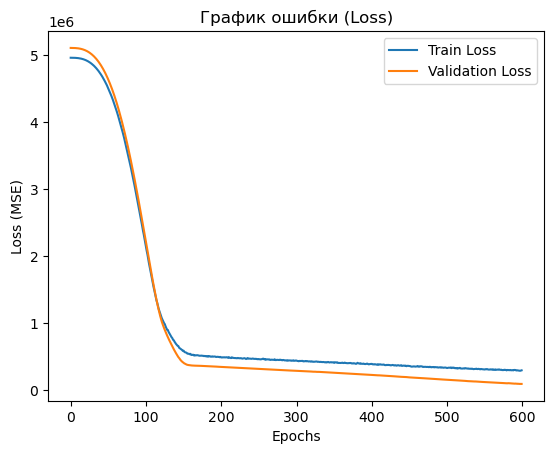

In [28]:
# График ошибки
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('График ошибки (Loss)')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step


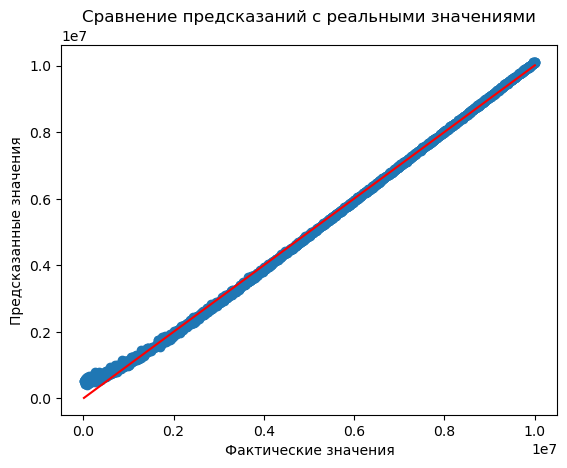

In [29]:
y_pred = model.predict(X_test_scaled)

plt.scatter(y_test, y_pred)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение предсказаний с реальными значениями')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Линия идеального предсказания
plt.show()